In [27]:
### IMPORTS ###
import os
import struct
import numpy as np
import math
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, fixed
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import ScalarFormatter

In [26]:
### SETTINGS ###
np.set_printoptions(precision=3, suppress=True, threshold=np.inf)

In [25]:
### FOLDER SETTINGS ###
input_folder = "../output/"

u_solution_path = input_folder + "/u.dat"
v_solution_path = input_folder + "/v.dat"
p_solution_path = input_folder + "/p.dat"
eta_solution_path = input_folder + "/eta.dat"
vel_div_path = input_folder + "/rhs.dat"
residual_path = input_folder + "/residual.dat"

In [24]:
format_string = '<d'  # '<d' for little-endian, '>d' for big-endian

In [28]:
with open(u_solution_path, 'rb') as f:
    data = np.fromfile(f, dtype=np.float64)
    u_approximate_solution = data

with open(v_solution_path, 'rb') as f:
    data = np.fromfile(f, dtype=np.float64)
    v_approximate_solution = data

with open(p_solution_path, 'rb') as f:
    data = np.fromfile(f, dtype=np.float64)
    p_approximate_solution = data

with open(eta_solution_path, 'rb') as f:
    data = np.fromfile(f, dtype=np.float64)
    eta_approximate_solution = data

with open(vel_div_path, 'rb') as f:
    data = np.fromfile(f, dtype=np.float64)
    vel_div = data

with open(residual_path, 'rb') as f:
    data = np.fromfile(f, dtype=np.float64)
    residual = data

u_approximate_solution = np.array(u_approximate_solution)    
v_approximate_solution = np.array(v_approximate_solution)
p_approximate_solution = np.array(p_approximate_solution)
eta_approximate_solution = np.array(eta_approximate_solution)
rhs = np.array(vel_div)
residual = np.array(residual)

In [29]:
def traveling_wave_1d(H, c, k, g, rho, sigma, h_small, w, t, x):

   z = sigma * h_small - h_small

   # Compute analytical solution at level z
   uu = k * H * c / 2 * np.cosh(k * (z + h_small)) / np.sinh(k * h_small) * np.cos(w * t - k * x)
   uu_x = k**2 * H * c / 2 * np.cosh(k * (z + h_small)) / np.sinh(k * h_small) * np.sin(w * t - k * x)

   ww = -k * H * c / 2 * np.sinh(k * (z + h_small)) / np.sinh(k * h_small) * np.sin(w * t - k * x)
   ww_z = -k**2 * H * c / 2 * np.cosh(k * (z + h_small)) / np.sinh(k * h_small) * np.sin(w * t - k * x)
   
   eta = H / 2 * np.cos(w * t - k * x)  # z = 0
   etax = k * H / 2 * np.sin(w * t - k * x)
   etaxx = -(k**2) * H / 2 * np.cos(w * t - k * x)
   
   pp_d= (-H) * c / 2 * np.cosh(k * (z + h_small)) / np.sinh(k * h_small) * np.sin(w * t - k * x)  # see p. 83 in Svendsen & Jonsson (2001)

   return uu, uu_x, ww, ww_z, eta, etax, etaxx, pp_d #+ pp_s

In [31]:
def plot_2D(true_solution, approximate_solution):
    error = np.abs(approximate_solution - true_solution)
    l2_error = np.linalg.norm(approximate_solution - true_solution, 2)
    print(f"Max error: {np.max(error):.1e}, L2-error: {l2_error:.1e}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # True solution plot
    cax1 = axes[0].imshow(true_solution, cmap='viridis', aspect='auto', origin='lower')
    axes[0].set_title('True Solution')
    fig.colorbar(cax1, ax=axes[0], orientation='vertical')

    # Approximate solution plot
    cax2 = axes[1].imshow(approximate_solution, cmap='viridis', aspect='auto', origin='lower')
    axes[1].set_title('Approximate Solution')
    fig.colorbar(cax2, ax=axes[1], orientation='vertical')

    # Error plot
    cax3 = axes[2].imshow(error, cmap='hot', aspect='auto', origin='lower')
    axes[2].set_title('Error')
    fig.colorbar(cax3, ax=axes[2], orientation='vertical')

    plt.tight_layout()
    plt.show()

In [30]:
def plot_2D_surface(X, SIGMA, u_approximate_solution, u_true, v_approximate_solution, v_true, p_approximate_solution, p_true, rhs, rhs_true, eta_approximate, eta_true):
    # Compute the L2 error for uu
    l2_uu_error = np.linalg.norm(u_approximate_solution - u_true, 2)
    max_uu_error = np.max(np.abs(u_approximate_solution - u_true))

    # Compute the L2 error for ww
    l2_ww_error = np.linalg.norm(v_approximate_solution - v_true, 2)
    max_ww_error = np.max(np.abs(v_approximate_solution - v_true))

    # Compute the L2 error for pp
    l2_pp_error = np.linalg.norm(p_approximate_solution - p_true, 2)
    max_pp_error = np.max(np.abs(p_approximate_solution - p_true))

    # Compute the L2 error for velocity divergence
    l2_vel_div_error = np.linalg.norm(rhs - rhs_true, 2)
    max_vel_div_error = np.max(np.abs(rhs - rhs_true))

    l2_eta_error = np.linalg.norm(eta_approximate - eta_true, 2)
    max_eta_error = np.max(np.abs(eta_approximate - eta_true))

    print('Pressure L2-error {:.3e}'.format(l2_pp_error) + ' Max error {:.3e}'.format(max_pp_error))
    print('Eta L2-error {:.3e}'.format(l2_eta_error) + ' Max error {:.3e}'.format(max_eta_error))

    # Create the figure for 3D surface plots
    fig = plt.figure(figsize=(15, 20))

    # First Row: uu plots
    # Plot Approximate Horizontal Velocity (uu)
    ax1 = fig.add_subplot(5, 3, 1, projection='3d')
    ax1.plot_surface(X, SIGMA, u_approximate_solution, cmap='viridis')
    ax1.set_title('Approximate Horizontal Velocity (uu)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('sigma')

    # Plot Horizontal Velocity (uu)
    ax2 = fig.add_subplot(5, 3, 2, projection='3d')
    ax2.plot_surface(X, SIGMA, u_true, cmap='viridis')
    ax2.set_title('Horizontal Velocity (uu)')
    ax2.set_xlabel('x')
    ax2.set_ylabel('sigma')

    # Plot Horizontal Velocity Error
    ax3 = fig.add_subplot(5, 3, 3, projection='3d')
    ax3.plot_surface(X, SIGMA, np.abs(u_approximate_solution - u_true), cmap='viridis')
    ax3.set_title('Horizontal Velocity Error (uu) L2: {:.3e}'.format(l2_uu_error) + ' MAX: {:.3e}'.format(max_uu_error))
    ax3.set_xlabel('x')
    ax3.set_ylabel('sigma')

    # Second Row: ww plots
    # Plot Approximate Vertical Velocity (ww)
    ax4 = fig.add_subplot(5, 3, 4, projection='3d')
    ax4.plot_surface(X, SIGMA, v_approximate_solution, cmap='viridis')
    ax4.set_title('Approximate Vertical Velocity (ww)')
    ax4.set_xlabel('x')
    ax4.set_ylabel('sigma')

    # Plot Vertical Velocity (ww)
    ax5 = fig.add_subplot(5, 3, 5, projection='3d')
    ax5.plot_surface(X, SIGMA, v_true, cmap='viridis')
    ax5.set_title('Vertical Velocity (ww)')
    ax5.set_xlabel('x')
    ax5.set_ylabel('sigma')

    # Plot Vertical Velocity Error
    ax6 = fig.add_subplot(5, 3, 6, projection='3d')
    ax6.plot_surface(X, SIGMA, np.abs(v_approximate_solution - v_true), cmap='viridis')
    ax6.set_title('Vertical Velocity Error (ww) L2: {:.3e}'.format(l2_ww_error) + ' MAX: {:.3e}'.format(max_ww_error))
    ax6.set_xlabel('x')
    ax6.set_ylabel('sigma')

    # Third Row: pp plots
    # Plot Approximate Pressure (pp)
    ax7 = fig.add_subplot(5, 3, 7, projection='3d')
    ax7.plot_surface(X, SIGMA, p_approximate_solution, cmap='viridis')
    ax7.set_title('Approximate Pressure (pp)')
    ax7.set_xlabel('x')
    ax7.set_ylabel('sigma')

    # Plot Pressure (pp)
    ax8 = fig.add_subplot(5, 3, 8, projection='3d')
    ax8.plot_surface(X, SIGMA, p_true, cmap='viridis')
    ax8.set_title('Pressure (pp)')
    ax8.set_xlabel('x')
    ax8.set_ylabel('sigma')

    # Plot Pressure Error
    ax9 = fig.add_subplot(5, 3, 9, projection='3d')
    ax9.plot_surface(X, SIGMA, np.abs(p_approximate_solution - p_true), cmap='viridis')
    ax9.set_title('Pressure Error (pp) L2: {:.3e}'.format(l2_pp_error) + ' MAX: {:.3e}'.format(max_pp_error))
    ax9.set_xlabel('x')
    ax9.set_ylabel('sigma')

    # Fourth Row: Velocity divergence plots
    # Plot Approximate Velocity Divergence
    ax10 = fig.add_subplot(5, 3, 10, projection='3d')
    ax10.plot_surface(X, SIGMA, rhs, cmap='viridis')
    ax10.set_title('Approximate Velocity Divergence')
    ax10.set_xlabel('x')
    ax10.set_ylabel('sigma')

    # Plot Velocity Divergence
    ax11 = fig.add_subplot(5, 3, 11, projection='3d')
    ax11.plot_surface(X, SIGMA, rhs_true, cmap='viridis')
    ax11.set_title('Velocity Divergence')
    ax11.set_xlabel('x')
    ax11.set_ylabel('sigma')

    # Plot Velocity Divergence Error
    ax12 = fig.add_subplot(5, 3, 12, projection='3d')
    ax12.plot_surface(X, SIGMA, np.abs(rhs - rhs_true), cmap='viridis')
    ax12.set_title('Velocity Divergence Error L2: {:.3e}'.format(l2_vel_div_error) + ' MAX: {:.3e}'.format(max_vel_div_error))
    ax12.set_xlabel('x')
    ax12.set_ylabel('sigma')

    # Plot approximate free surface eta
    ax13 = fig.add_subplot(5, 3, 13)
    ax13.plot(X[0,:], eta_approximate)
    ax13.set_title('Approximate Free Surface Elevation')
    ax13.set_xlabel('x')
    ax13.set_ylabel('eta')

    # Plot true free surface eta
    ax14 = fig.add_subplot(5, 3, 14)
    ax14.plot(X[0,:], eta_true[0,:])
    ax14.set_title('True Free Surface Elevation')
    ax14.set_xlabel('x')
    ax14.set_ylabel('eta')

    # Plot free surface eta error
    ax15 = fig.add_subplot(5, 3, 15)
    ax15.plot(X[0,:], np.abs(eta_approximate - eta_true[0,:]))
    ax15.set_title('Free Surface Elevation Error L2: {:.3e}'.format(l2_eta_error) + ' MAX: {:.3e}'.format(max_eta_error))
    ax15.set_xlabel('x')
    ax15.set_ylabel('eta')

    # Adjust the spacing between the plots
    #plt.subplots_adjust(wspace=1, hspace=1)
    #plt.tight_layout()
    plt.savefig('Travelling_wave_plot.jpg', dpi=300, transparent=False)
    plt.show()
    return

In [33]:
def plot_2D_imshow(X, SIGMA, u_approximate_solution, u_true, v_approximate_solution, v_true, p_approximate_solution, p_true, vel_div_approximate, vel_div_true):
    # Compute the L2 error for uu
    l2_uu_error = np.linalg.norm(u_approximate_solution - u_true)
    max_uu_error = np.max(np.abs(u_approximate_solution - u_true))

    # Compute the L2 error for ww
    l2_ww_error = np.linalg.norm(v_approximate_solution - v_true)
    max_ww_error = np.max(np.abs(v_approximate_solution - v_true))

    # Compute the L2 error for pp
    l2_pp_error = np.linalg.norm(p_approximate_solution - p_true)
    max_pp_error = np.max(np.abs(p_approximate_solution - p_true))

    # Compute the L2 error for velocity divergence
    l2_vel_div_error = np.linalg.norm(vel_div_approximate - vel_div_true)
    max_vel_div_error = np.max(np.abs(vel_div_approximate - vel_div_true))

    # Create the figure for 2D image plots
    fig = plt.figure(figsize=(15, 20))
    titles = [
        'Approximate Horizontal Velocity (uu)', 'Horizontal Velocity (uu)', 'Horizontal Velocity Error',
        'Approximate Vertical Velocity (ww)', 'Vertical Velocity (ww)', 'Vertical Velocity Error',
        'Approximate Pressure (pp)', 'Pressure (pp)', 'Pressure Error',
        'Approximate Velocity Divergence', 'Velocity Divergence', 'Velocity Divergence Error'
    ]
    data_series = [
        u_approximate_solution, u_true, np.abs(u_approximate_solution - u_true),
        v_approximate_solution, v_true, np.abs(v_approximate_solution - v_true),
        p_approximate_solution, p_true, np.abs(p_approximate_solution - p_true),
        vel_div_approximate, vel_div_true, np.abs(vel_div_approximate - vel_div_true)
    ]

    for i in range(12):
        ax = fig.add_subplot(4, 3, i+1)
        cax = ax.imshow(data_series[i], extent=[X.min(), X.max(), SIGMA.min(), SIGMA.max()], origin='lower', aspect='auto', cmap='viridis')
        ax.set_title(titles[i])
        ax.set_xlabel('x')
        ax.set_ylabel('sigma')
        fig.colorbar(cax, ax=ax, orientation='vertical')

    # Adjust the spacing between the plots and show the figure
    plt.subplots_adjust(wspace=0.5, hspace=0.6)
    plt.show()

In [32]:
### PARAMETERS ###

# Grid parameters
ndims = 2
num_data_per_elements = 1

x_grid = 128
sigma_grid = 128

x_ghost_points = 0
sigma_ghost_points = 0

# Physical parameters
g = 9.81
rho = 1.0

Lx = 31.0
Ls = 1.0

kh = 1.0
lwave = Lx
kwave = 2 * np.pi / lwave
hd = kh/kwave
cwave = np.sqrt(g/kwave*np.tanh(kh))
Twave = lwave/cwave
wwave = 2 * np.pi / Twave
Hwave = 0.02

t0 = 0.0
t1 = 1/1000
current_t = t1

# Lx,Ls
domain_begin_array = np.array([0.0, 0.0])
domain_end_array = np.array([Lx, Ls])

x = np.linspace(domain_begin_array[0], domain_end_array[0], x_grid)
sigma = np.linspace(domain_begin_array[1], domain_end_array[1], sigma_grid)

X, SIGMA = np.meshgrid(x, sigma)

In [35]:
u_layout = (sigma_grid, x_grid+x_ghost_points, num_data_per_elements)
v_layout = (sigma_grid, x_grid+x_ghost_points, num_data_per_elements)
p_layout = (sigma_grid+sigma_ghost_points, x_grid+x_ghost_points, num_data_per_elements)
eta_layout = (x_grid+x_ghost_points, num_data_per_elements)

print("u_layout: ", u_layout)
print("v_layout: ", v_layout)
print("p_layout: ", p_layout)
print("eta_layout: ", eta_layout)

u_layout:  (128, 128, 1)
v_layout:  (128, 128, 1)
p_layout:  (128, 128, 1)
eta_layout:  (128, 1)


In [34]:
# Reshape the data into a 2D array
u_approximate_solution = u_approximate_solution.reshape(u_layout)
v_approximate_solution = v_approximate_solution.reshape(v_layout)
p_approximate_solution = p_approximate_solution.reshape(p_layout)
eta_approximate_solution = eta_approximate_solution.reshape(eta_layout)
rhs = rhs.reshape(p_layout)
residual = residual.reshape(p_layout)

u_approximate_solution = np.squeeze(u_approximate_solution)
v_approximate_solution = np.squeeze(v_approximate_solution)
p_approximate_solution = np.squeeze(p_approximate_solution)
eta_approximate_solution = np.squeeze(eta_approximate_solution)
rhs = np.squeeze(rhs)
residual = np.squeeze(residual)

#u_approximate_solution = u_approximate_solution[0:sigma_grid, 1:x_grid+1]
#v_approximate_solution = v_approximate_solution[0:sigma_grid, 1:x_grid+1]
#p_approximate_solution = p_approximate_solution[1:sigma_grid+1, 1:x_grid+1]

u_approximate_solution = u_approximate_solution.T
v_approximate_solution = v_approximate_solution.T
p_approximate_solution = p_approximate_solution.T
#eta_approximate_solution = eta_approximate_solution.T
rhs = rhs.T
residual = residual.T

print("u_approximate_solution.shape: ", u_approximate_solution.shape)
print("v_approximate_solution.shape: ", v_approximate_solution.shape)
print("p_approximate_solution.shape: ", p_approximate_solution.shape)
print("eta_approximate_solution.shape: ", eta_approximate_solution.shape)
print("vel_div.shape: ", rhs.shape)
print("residual.shape: ", residual.shape)

u_approximate_solution.shape:  (128, 128)
v_approximate_solution.shape:  (128, 128)
p_approximate_solution.shape:  (128, 128)
eta_approximate_solution.shape:  (128,)
vel_div.shape:  (128, 128)
residual.shape:  (128, 128)


In [36]:
# Plotting each component at a time
uu, uu_x, ww, ww_z, eta, etax, etaxx, pp = traveling_wave_1d(Hwave, cwave, kwave, g, rho, SIGMA, hd, wwave, current_t, X)
vel_div_analytical = uu_x + ww_z

In [37]:
# Iterative solver results

# NxM, stencil size, L2-error, Max error

# 16x16, 3x3, 1.203e-02 1.432e-03
# 32x32, 3x3, 5.138e-03 3.069e-04
# 64x64, 3x3, 2.368e-03 7.096e-05
# 128x128, 3x3, 9.964e-04 1.490e-05

# 16x16, 5x5, 1.143e-03 2.404e-04
# 32x32, 5x5, 9.182e-05 1.155e-05
# 64x64, 5x5, 6.751e-06 4.467e-07
# 128x128, 5x5, 4.930e-07 1.584e-08

# 16x16, 7x7, 1.257e-04 2.781e-05
# 32x32, 7x7, 2.847e-06 3.874e-07
# 64x64, 7x7, 4.906e-08 3.714e-09
# 128x128, 7x7, 7.621e-10 3.194e-11

In [41]:
#print(pp_s)
#print(pp_d)
#print(pp)

Max error: 1.3e-04, L2-error: 3.8e-03


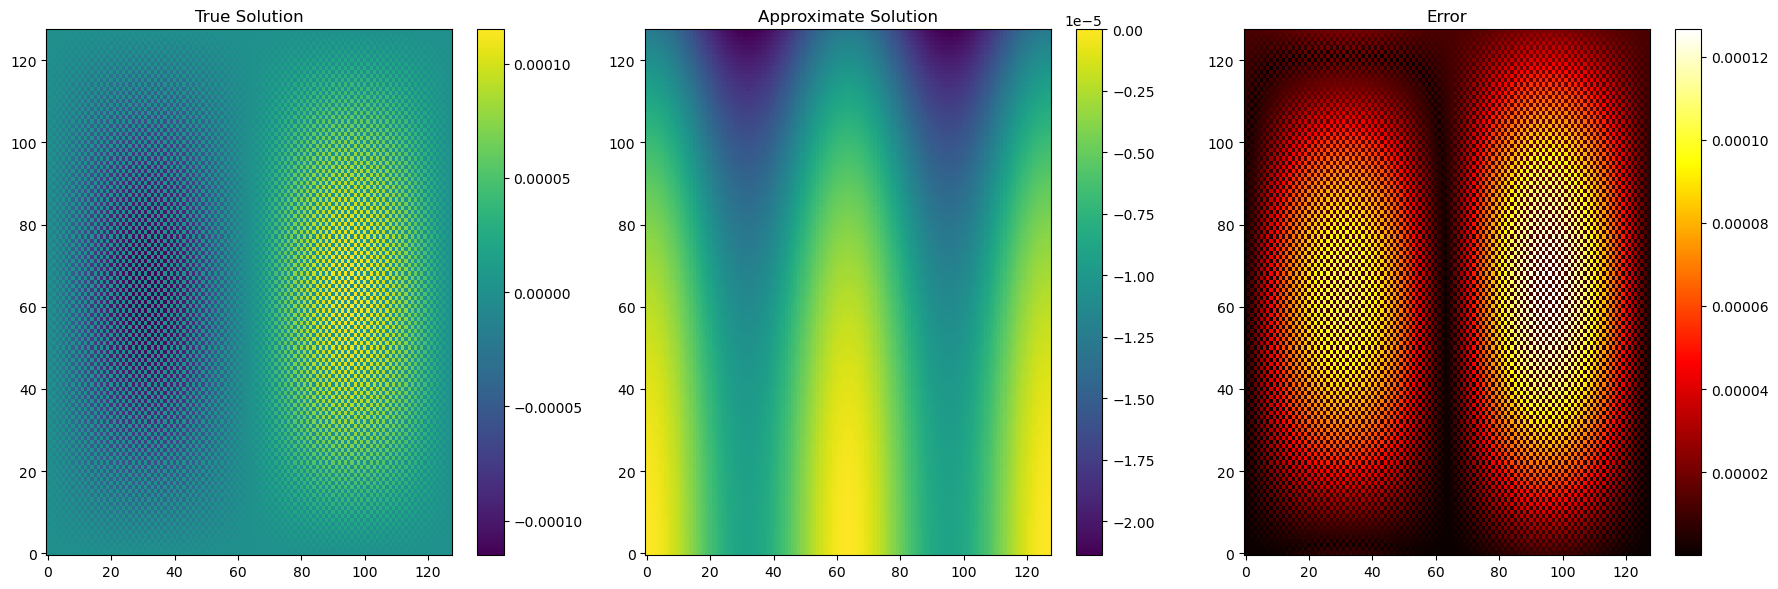

In [40]:
plot_2D(residual,rhs)

Pressure L2-error 1.014e-02 Max error 1.731e-04
Eta L2-error 1.556e+00 Max error 1.995e-02


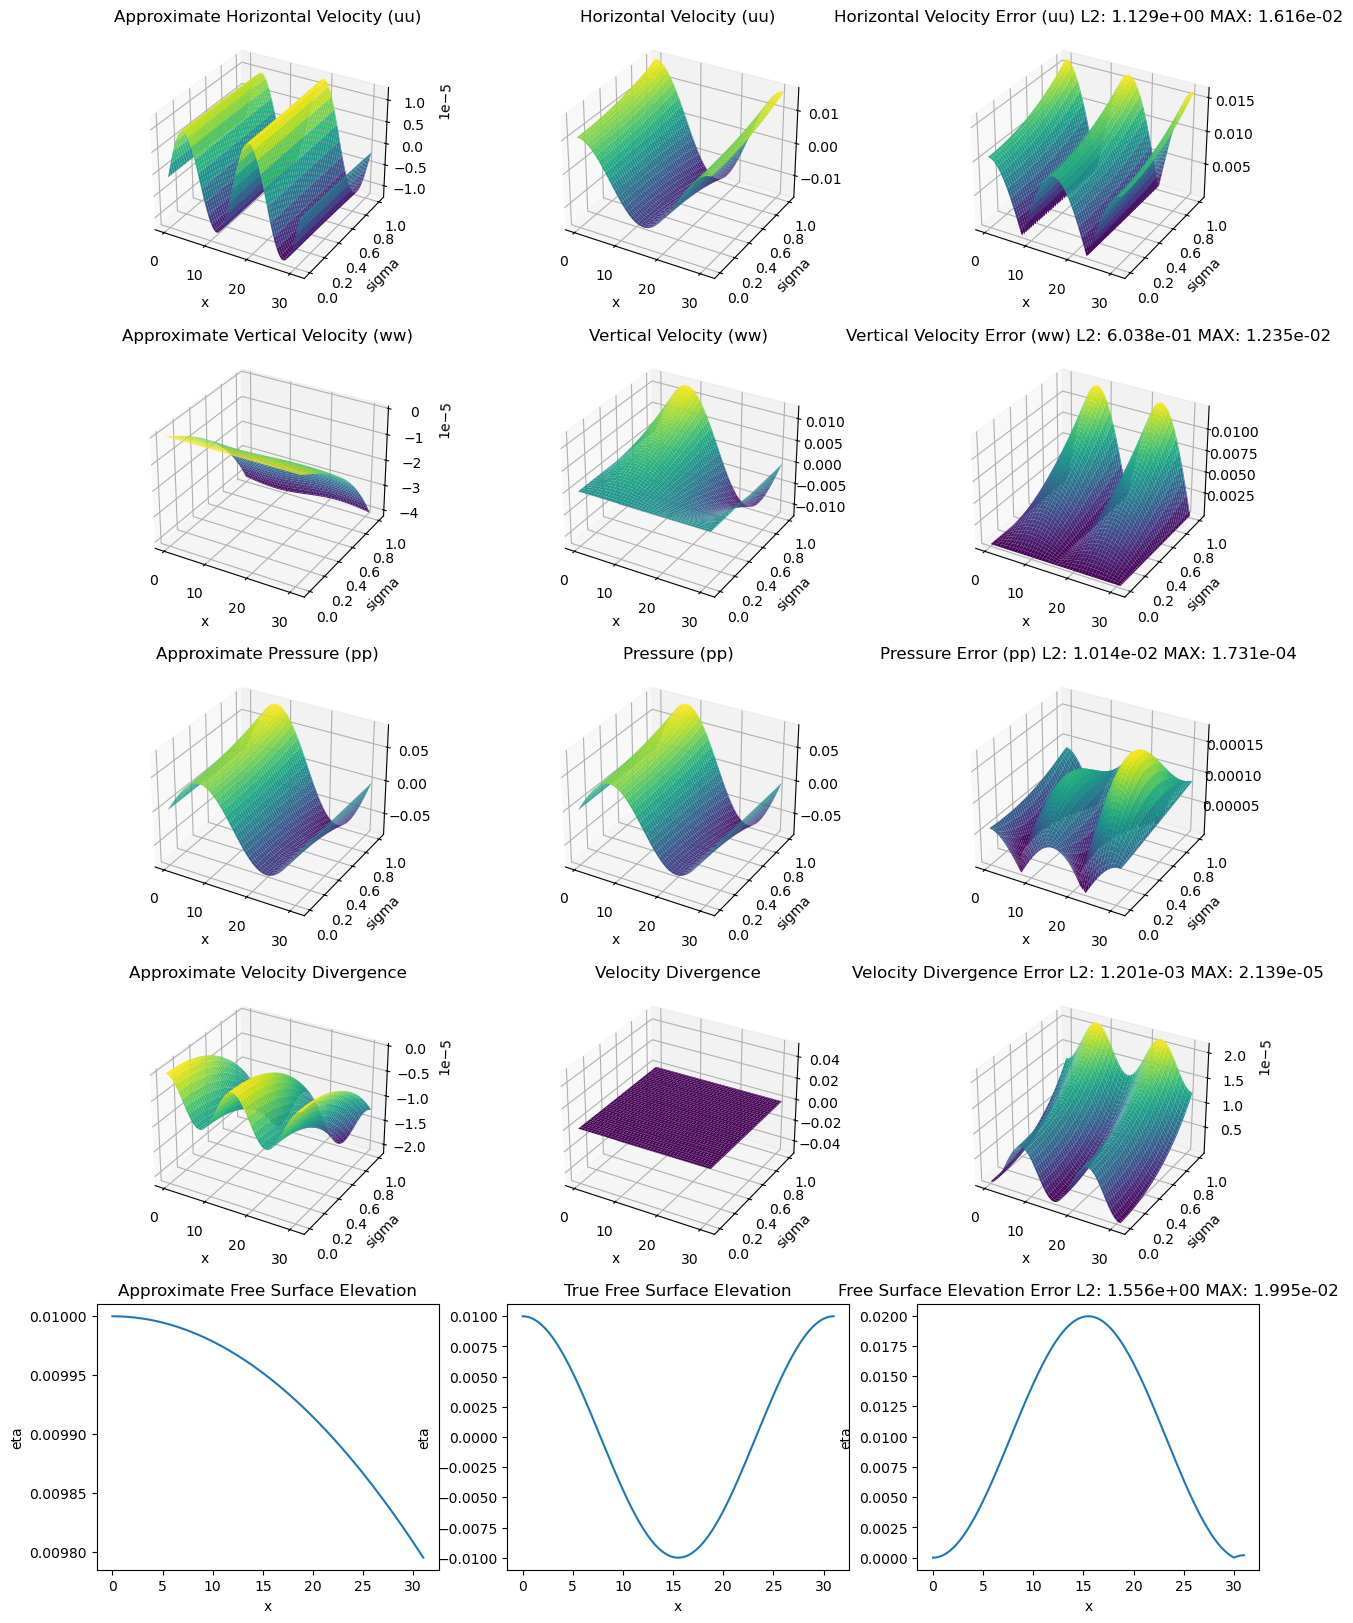

In [38]:
plot_2D_surface(X, SIGMA, u_approximate_solution, uu, v_approximate_solution, ww, p_approximate_solution, pp, rhs, vel_div_analytical, eta_approximate_solution, eta)

In [39]:
#plot_2D_imshow(X, SIGMA, u_approximate_solution, uu, v_approximate_solution, ww, p_approximate_solution, pp, vel_div, vel_div_analytical)

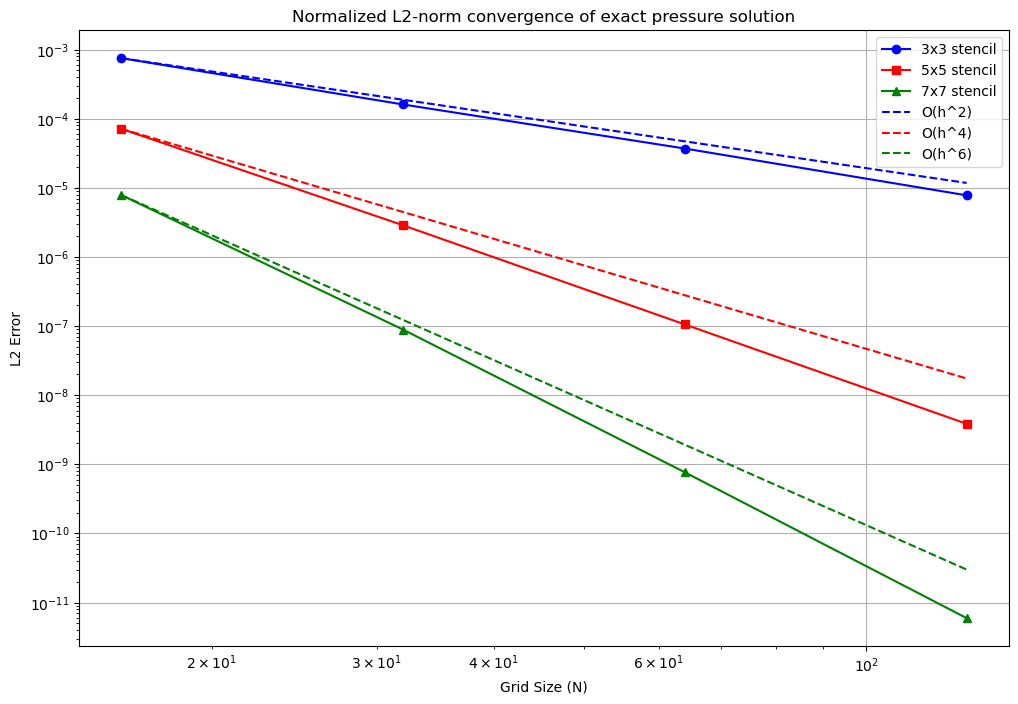

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Prepare the data
grid_sizes = [16, 32, 64, 128] * 4
stencil_sizes = ['3x3'] * 4 + ['5x5'] * 4 + ['7x7'] * 4
l2_errors = [1.203e-02, 5.138e-03, 2.368e-03, 9.964e-04,
             1.143e-03, 9.182e-05, 6.751e-06, 4.930e-07,
             1.257e-04, 2.847e-06, 4.906e-08, 7.621e-10]

# Normalize the L2 errors by the number of points
normalized_l2_errors = [error / np.sqrt(size**2) for error, size in zip(l2_errors, grid_sizes)]

# Step 2: Create arrays for each stencil size
grid_3x3 = np.array(grid_sizes[:4])
grid_5x5 = np.array(grid_sizes[4:8])
grid_7x7 = np.array(grid_sizes[8:12])

# For L2 errors
error_3x3 = np.array(normalized_l2_errors[:4])
error_5x5 = np.array(normalized_l2_errors[4:8])
error_7x7 = np.array(normalized_l2_errors[8:12])

# Step 3: Create the plot
plt.figure(figsize=(12, 8))
plt.loglog(grid_3x3, error_3x3, 'bo-', label='3x3 stencil')
plt.loglog(grid_5x5, error_5x5, 'rs-', label='5x5 stencil')
plt.loglog(grid_7x7, error_7x7, 'g^-', label='7x7 stencil')

# Step 4: Add convergence lines
grid_range = np.logspace(np.log10(16), np.log10(128), 100)
h = 1 / grid_range

# O(h^2) convergence line
c2 = error_3x3[0] * (16**2)  # Constant to match the first point of 3x3 stencil
plt.loglog(grid_range, c2 * h**2, 'b--', label='O(h^2)')

# O(h^4) convergence line
c4 = error_5x5[0] * (16**4)  # Constant to match the first point of 5x5 stencil
plt.loglog(grid_range, c4 * h**4, 'r--', label='O(h^4)')

# O(h^6) convergence line
c6 = error_7x7[0] * (16**6)  # Constant to match the first point of 7x7 stencil
plt.loglog(grid_range, c6 * h**6, 'g--', label='O(h^6)')

# Step 5: Add labels and title
plt.xlabel('Grid Size (N)')
plt.ylabel('L2 Error')
plt.title('Normalized L2-norm convergence of exact pressure solution')
plt.legend()
plt.grid(True)

# Step 6: Show the plot
plt.savefig('Travelling_wave_convergence_plot.jpg', dpi=300, transparent=False)
plt.show()
